In [1]:
import os
import torch
import clip
import numpy as np
from PIL import Image
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt


https://github.com/Dheeraj31104/aml_homework_4_question1.git

In [2]:
device = "mps" if torch.cuda.is_available() else "cpu"

model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [3]:
CLASSES = [
    "airplane", "car", "chair", "cup",
    "dog", "donkey", "duck", "hat"
]
class_to_label = {cls: i for i, cls in enumerate(CLASSES)}
NUM_CLASSES = len(CLASSES)

text_prompts = [f"a photo of a {c}" for c in CLASSES]
text_tokens = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    text_features = model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)


In [4]:
def evaluate_condition(condition_dir):
    y_true = []
    y_pred = []

    for fname in os.listdir(condition_dir):

        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        lower_name = fname.lower()
        true_label = None

        # IMPORTANT: match longer names first (donkey before dog)
        for cls in sorted(CLASSES, key=len, reverse=True):
            if cls in lower_name:
                true_label = class_to_label[cls]
                break

        # Skip files that do not match any class
        if true_label is None:
            continue

        img_path = os.path.join(condition_dir, fname)

        image = Image.open(img_path).convert("RGB")
        image = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image)
            image_features = image_features / image_features.norm(dim=1, keepdim=True)

            similarities = image_features @ text_features.T
            pred_label = similarities.argmax(dim=1).item()

        y_true.append(true_label)
        y_pred.append(pred_label)

    return np.array(y_true), np.array(y_pred)


In [5]:
def plot_confusion_matrix_with_numbers(cm, labels, title):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)

    # Tick labels
    ax.set(
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
        xlabel="Predicted Label",
        ylabel="True Label",
        title=title
    )

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Add numbers inside cells
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, int(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.tight_layout()
    plt.show()

In [ ]:
DATASET_ROOT = "/Users/jaswanthravipati/Downloads/image_files/v0"   
CONDITIONS = ["realistic", "geons", "silhouettes", "blurred", "features"]

results = {}

for cond in CONDITIONS:
    print(f"\nEvaluating condition: {cond}")
    cond_path = os.path.join(DATASET_ROOT, cond)

    y_true, y_pred = evaluate_condition(cond_path)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))
    accuracy = np.trace(cm) / np.sum(cm)

    results[cond] = {
        "confusion_matrix": cm,
        "accuracy": accuracy
    }



Evaluating condition: realistic

Evaluating condition: geons

Evaluating condition: silhouettes

Evaluating condition: blurred

Evaluating condition: features



=== Condition: realistic ===
Accuracy: 1.0000
Confusion Matrix:


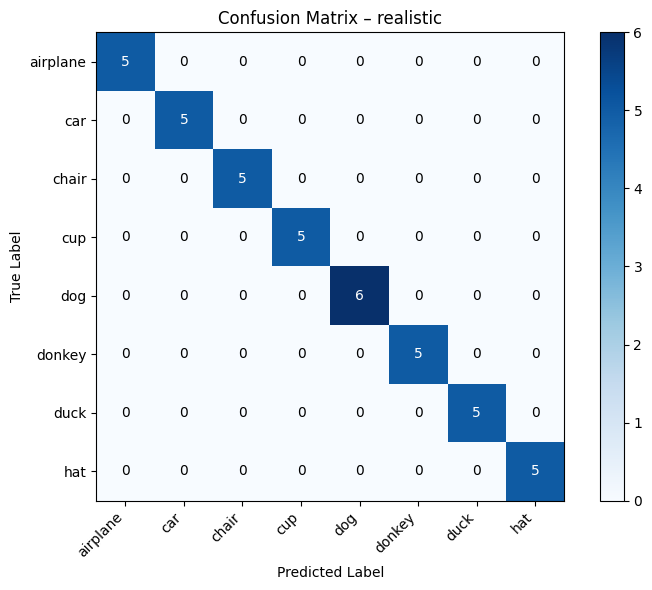


=== Condition: geons ===
Accuracy: 0.5085
Confusion Matrix:


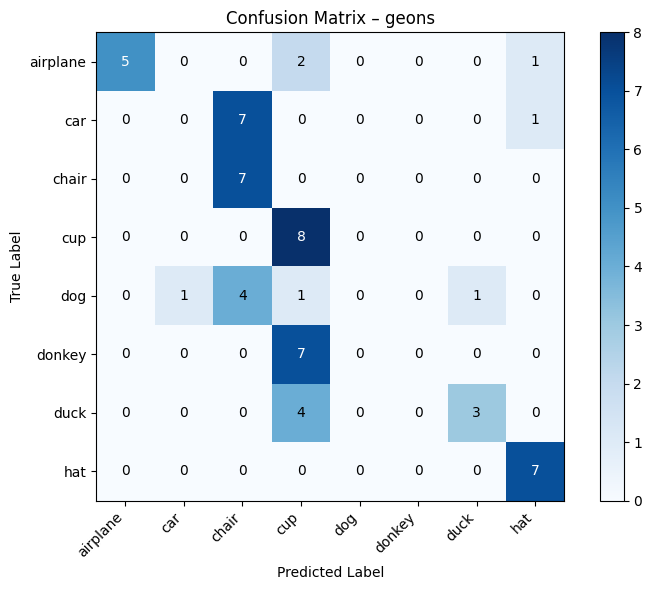


=== Condition: silhouettes ===
Accuracy: 0.8500
Confusion Matrix:


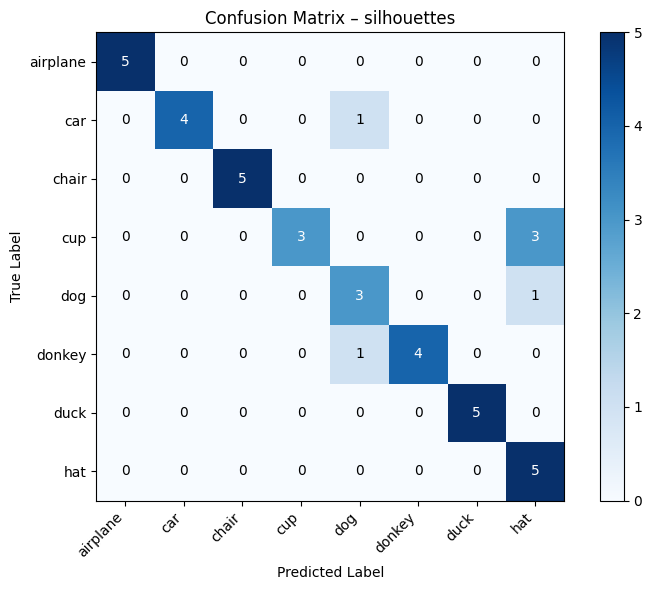


=== Condition: blurred ===
Accuracy: 0.7143
Confusion Matrix:


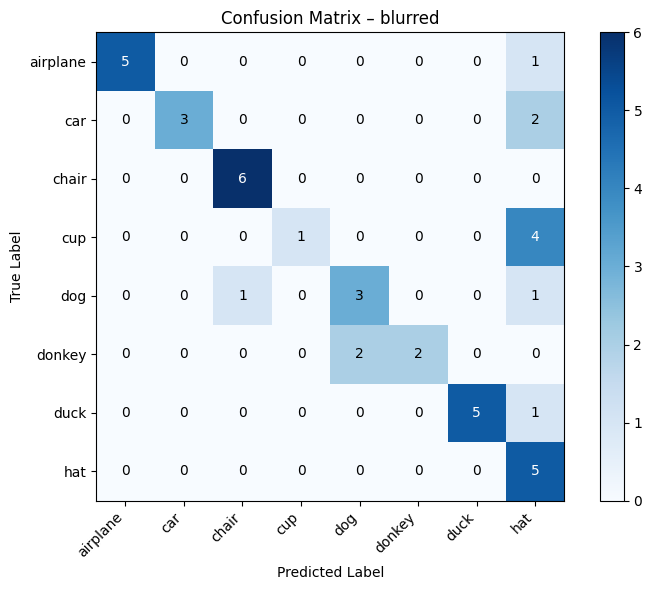


=== Condition: features ===
Accuracy: 0.6585
Confusion Matrix:


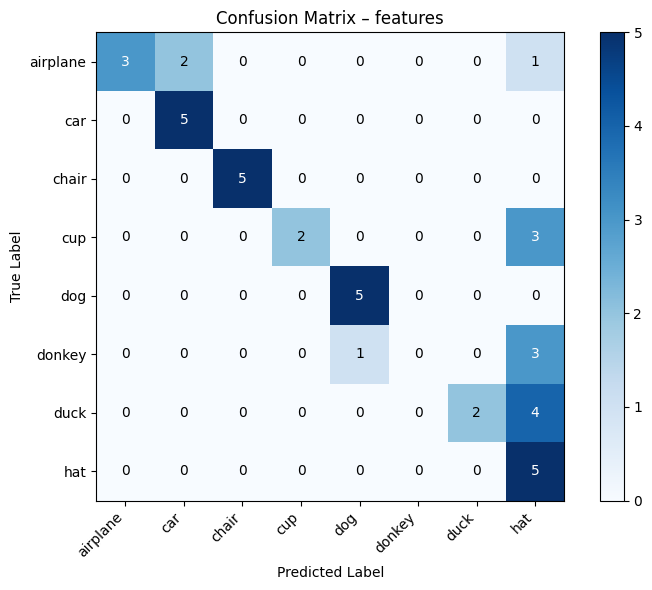

In [7]:
for cond in CONDITIONS:
    print(f"\n=== Condition: {cond} ===")
    print(f"Accuracy: {results[cond]['accuracy']:.4f}")
    print("Confusion Matrix:")
    plot_confusion_matrix_with_numbers(
        results[cond]["confusion_matrix"],
        CLASSES,
        f"Confusion Matrix – {cond}"
    )


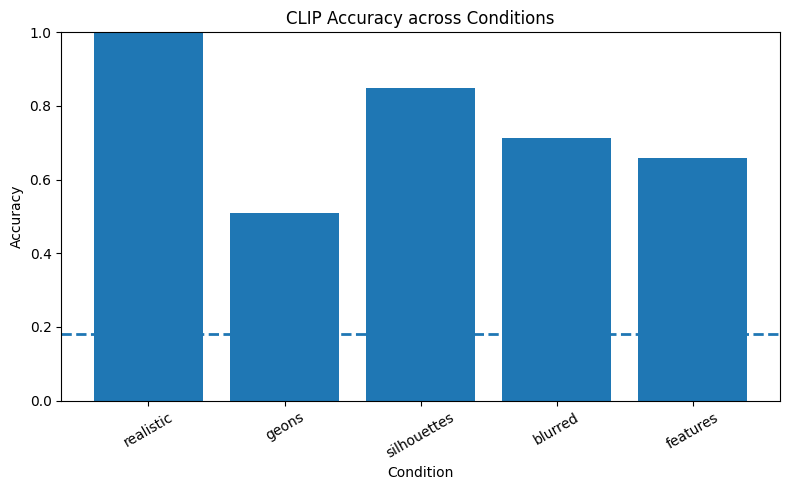

In [8]:
# Extract accuracies
conditions = list(results.keys())
accuracies = [results[c]["accuracy"] for c in conditions]

plt.figure(figsize=(8, 5))

# Bar plot
plt.bar(conditions, accuracies)

# Horizontal dotted line at y = 0.18
plt.axhline(
    y=0.18,
    linestyle="--",
    linewidth=2
)

# Labels and title
plt.ylabel("Accuracy")
plt.xlabel("Condition")
plt.title("CLIP Accuracy across Conditions")

# Rotate x labels slightly for readability
plt.xticks(rotation=30)

# Set y-axis limit for clarity
plt.ylim(0, 1.0)

plt.tight_layout()
plt.show()
